# Set WD and Read Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/TikTok Hackathon'

/content/drive/MyDrive/TikTok Hackathon


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
ads = pd.read_excel("Dataset.xlsx", skiprows=1, sheet_name=0)
rev = pd.read_excel("Dataset.xlsx", sheet_name=1)

In [ ]:
len(ads)

40679

# Ads Data Cleaning

In [ ]:
ads[ads['punish_num'].isna()]['latest_punish_begin_date'].unique()    # Replace punish_num with 0 where latest_punish_begin_date is "2000-01-01" (i.e. NA currently)

array(['2000-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
#all NA punish nums are supposed to be 0
ads['punish_num'] = ads['punish_num'].fillna(0)

# Drop rows with missing values
ads.dropna(inplace = True, subset=['ad_revenue', 'start_time'])     ##keep NAs of queue_market

In [ ]:
len(ads)

29908

# Ads Priority Scoring

We propose log transformation for all 3 to make the distribution less skewed and more comparable.

In [ ]:
# Log transformation for 3 predictors - add a small value for log for 0 values
ads['punish_num'] += 0.1
ads['ad_revenue'] += 0.001
ads['avg_ad_revenue'] += 0.001

ads['v1'] = np.log(ads['punish_num'])
ads['v2'] = np.log(ads['ad_revenue'])
ads['v3'] = np.log(ads['avg_ad_revenue'])

In [ ]:
plt.style.use('ggplot')

We compare the distributions before and after the transformation

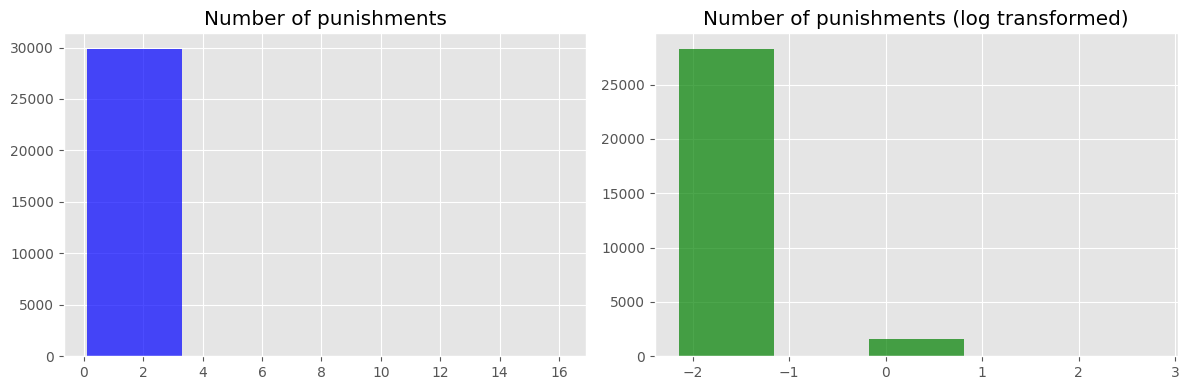

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # Create a figure with two subplots side by side

# Plot the first histogram on the first subplot
ax[0].hist(ads['punish_num'], bins=5, color='blue', alpha=0.7)
ax[0].set_title('Number of punishments')

# Plot the second histogram on the second subplot
ax[1].hist(ads['v1'], bins=5, color='green', alpha=0.7)
ax[1].set_title('Number of punishments (log transformed)')

plt.tight_layout()  # Adjust subplot layout to prevent overlapping
plt.show()

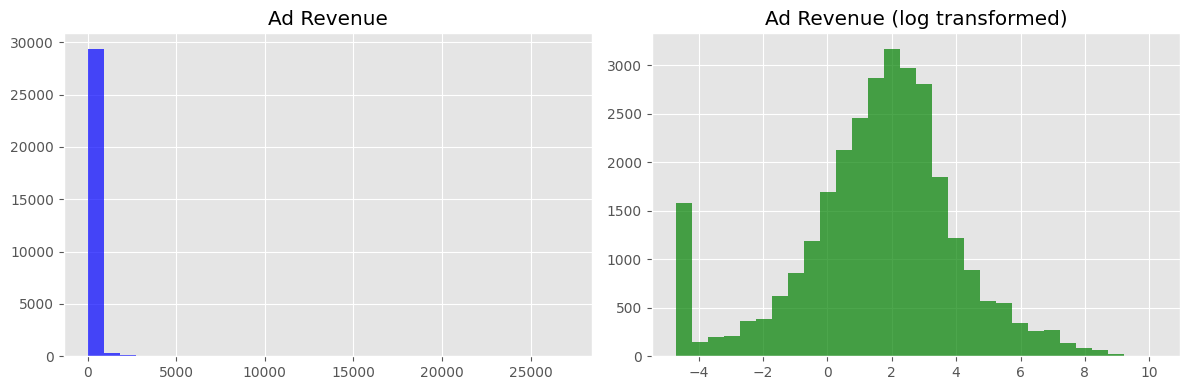

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # Create a figure with two subplots side by side

# Plot the first histogram on the first subplot
ax[0].hist(ads['ad_revenue'], bins=30, color='blue', alpha=0.7)
ax[0].set_title('Ad Revenue')

# Plot the second histogram on the second subplot
ax[1].hist(ads['v2'], bins=30, color='green', alpha=0.7)
ax[1].set_title('Ad Revenue (log transformed)')

plt.tight_layout()  # Adjust subplot layout to prevent overlapping
plt.show()

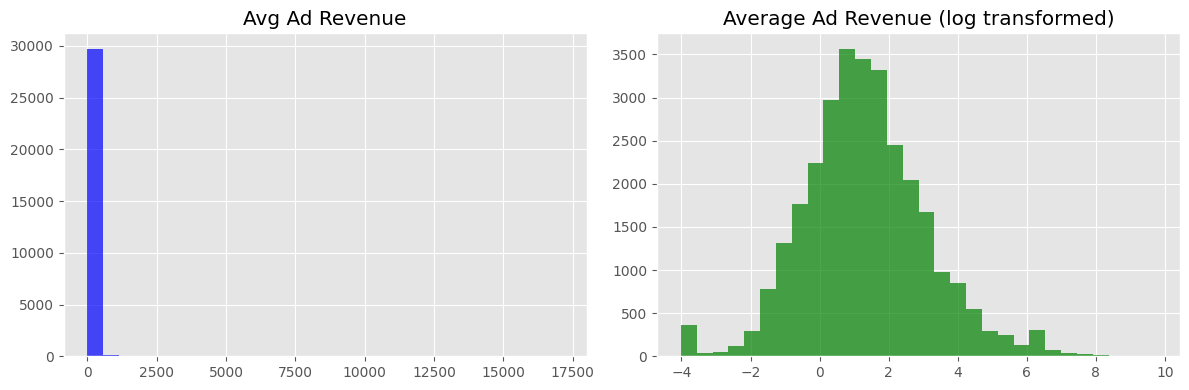

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # Create a figure with two subplots side by side

# Plot the first histogram on the first subplot
ax[0].hist(ads['avg_ad_revenue'], bins=30, color='blue', alpha=0.7)
ax[0].set_title('Avg Ad Revenue')

# Plot the second histogram on the second subplot
ax[1].hist(ads['v3'], bins=30, color='green', alpha=0.7)
ax[1].set_title('Average Ad Revenue (log transformed)')

plt.tight_layout()  # Adjust subplot layout to prevent overlapping
plt.show()

The distribution of each column to be used along with their coefficients (weights).

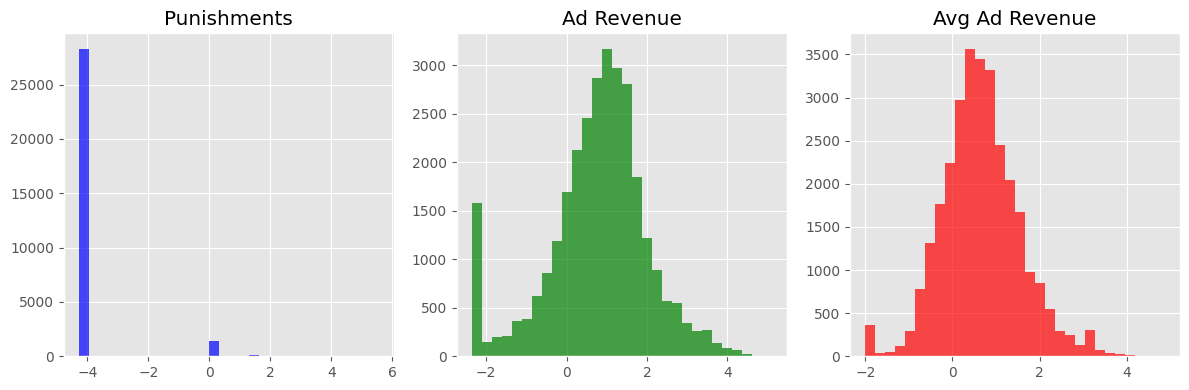

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))  # Create a figure with two subplots side by side

## Ad revenues are weighted equally, punishment weight is slightly stronger to penalize ones with higher punishments more.

# Plot the first histogram on the first subplot
ax[0].hist(2 * ads['v1'], bins=30, color='blue', alpha=0.7)
ax[0].set_title('Punishments')

# Plot the second histogram on the second subplot
ax[1].hist(0.5 * ads['v2'], bins=30, color='green', alpha=0.7)
ax[1].set_title('Ad Revenue')

ax[2].hist(0.5 * ads['v3'], bins=30, color='red', alpha=0.7)
ax[2].set_title('Avg Ad Revenue')

plt.tight_layout()  # Adjust subplot layout to prevent overlapping
plt.show()

The following formula is used for calculating the priority score. Note that although, higher punishment is bad for an ad, we still give it a positive score since we want higher skilled moderators to look at ads with higher punishments.

In [ ]:
# Compute the score column
ads['score'] = (2 * ads['v1'] + 0.5 * ads['v2'] + 0.5 * ads['v3']) * ads['baseline_st']

The ad scores are scaled to 0-1 and have the following distribution.

In [ ]:
def feature_scaling(X):
    min = X.min()
    max = X.max()
    output = (X - min) / (max-min)
    return output

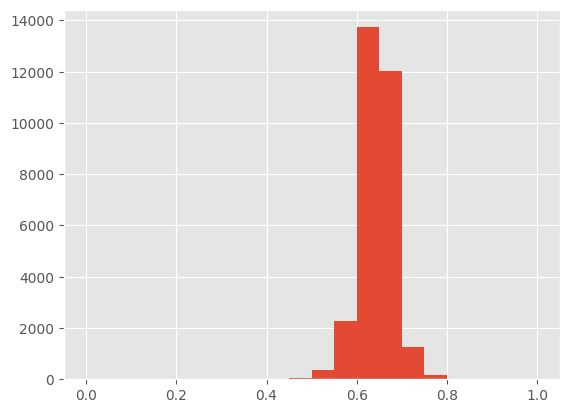

In [ ]:
# Rescale the score column
_ = plt.hist(feature_scaling(ads['score']), bins = 20)

In [ ]:
ads['scaled_score'] = feature_scaling(ads['score'])

In [ ]:
ads.to_csv('ads_scored.csv', index=False)

# Moderator Data Cleaning

The reviewers dataset is prepared by recoding accuracy column and droping NAs

In [ ]:
rev.columns

Index(['moderator', 'market', 'Productivity', 'Utilisation %', 'handling time',
       ' accuracy '],
      dtype='object')

In [ ]:
len(rev)

1275

In [ ]:
rev = rev.rename(columns={' accuracy ': 'accuracy'})

In [ ]:
rev['accuracy'] = rev['accuracy'].replace(rev['accuracy'].unique()[0], np.nan)
rev['accuracy'] = pd.to_numeric(rev['accuracy'], errors='coerce').astype('float64')

In [28]:
rev.dropna(inplace = True)

In [29]:
len(rev)

1275

# Moderator Priority Scoring

In [ ]:
sum(rev['accuracy']==0)

0

In [ ]:
sum(rev['handling time']==0)

0

We use the following transformations for the 3 columns to be used in reviewers scoring.

In [ ]:
rev['v1'] = np.sqrt(rev['Productivity'])
rev['v2'] = np.log(rev['accuracy'])
rev['v3'] = np.log(rev['handling time'])

Producitivity has better distribution when square rooted vs log.

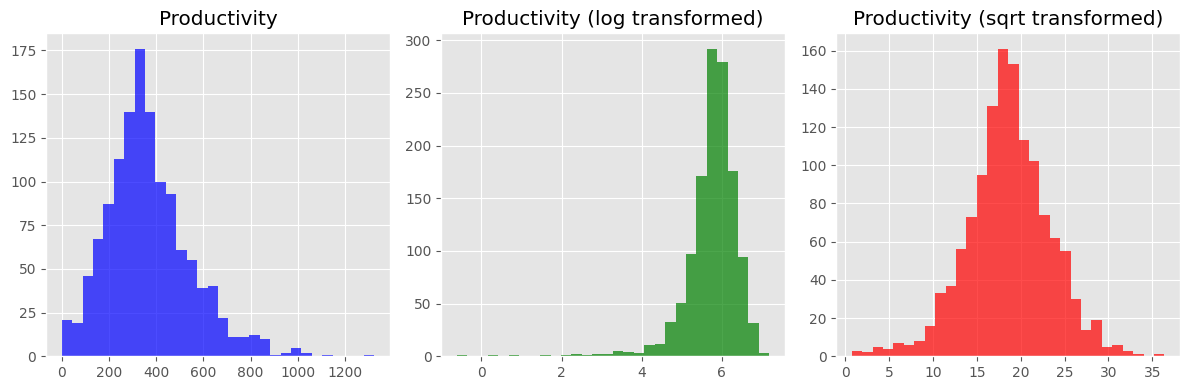

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))  # Create a figure with two subplots side by side

# Plot the first histogram on the first subplot
ax[0].hist(rev['Productivity'], bins=30, color='blue', alpha=0.7)
ax[0].set_title('Productivity')

# Plot the second histogram on the second subplot
ax[1].hist(np.log(rev['Productivity']), bins=30, color='green', alpha=0.7)
ax[1].set_title('Productivity (log transformed)')

ax[2].hist(rev['v1'], bins=30, color='red', alpha=0.7)
ax[2].set_title('Productivity (sqrt transformed)')

plt.tight_layout()  # Adjust subplot layout to prevent overlapping
plt.show()

It doesn't make sense to transform accuracy, besides it's already in a good range between 0-1.

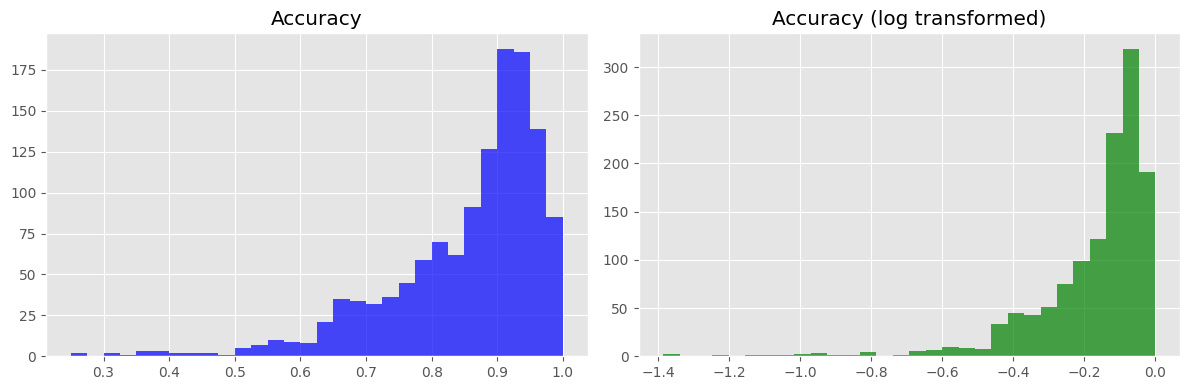

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # Create a figure with two subplots side by side

# Plot the first histogram on the first subplot
ax[0].hist(rev['accuracy'], bins=30, color='blue', alpha=0.7)
ax[0].set_title('Accuracy')

# Plot the second histogram on the second subplot
ax[1].hist(rev['v2'], bins=30, color='green', alpha=0.7)
ax[1].set_title('Accuracy (log transformed)')


plt.tight_layout()  # Adjust subplot layout to prevent overlapping
plt.show()

Log for handling time is usefule especially because handling time is very skewed and has high values.

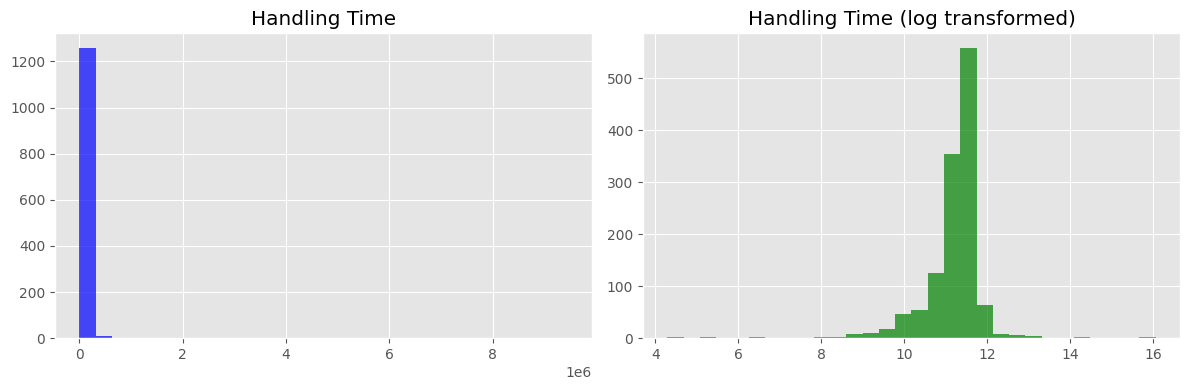

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # Create a figure with two subplots side by side

# Plot the first histogram on the first subplot
ax[0].hist(rev['handling time'], bins=30, color='blue', alpha=0.7)
ax[0].set_title('Handling Time')

# Plot the second histogram on the second subplot
ax[1].hist(rev['v3'], bins=30, color='green', alpha=0.7)
ax[1].set_title('Handling Time (log transformed)')


plt.tight_layout()  # Adjust subplot layout to prevent overlapping
plt.show()

These are the final distributions of the columns along with their coefficients to be used. Higher handling times are negatively penalized.

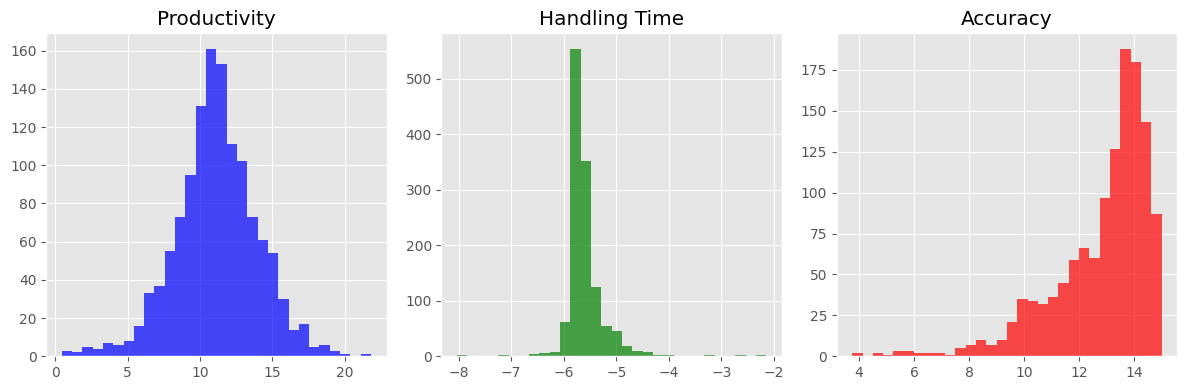

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))  # Create a figure with two subplots side by side

# Plot the first histogram on the first subplot
ax[0].hist(0.6 * rev['v1'], bins=30, color='blue', alpha=0.7)
ax[0].set_title('Productivity')

# Plot the second histogram on the second subplot
ax[1].hist(- 0.5 * rev['v3'], bins=30, color='green', alpha=0.7)
ax[1].set_title('Handling Time')

ax[2].hist(15 * rev['accuracy'], bins=30, color='red', alpha=0.7)
ax[2].set_title('Accuracy')


plt.tight_layout()  # Adjust subplot layout to prevent overlapping
plt.show()

In [ ]:
# Compute the score column
rev['score'] = 0.6 * rev['v1'] - 0.5 * rev['v3'] + 15 * rev['accuracy']

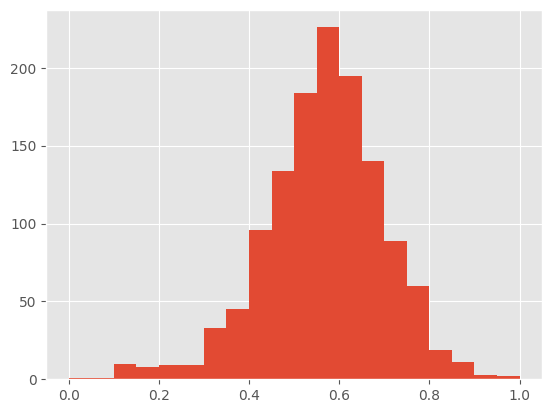

In [ ]:
_ = plt.hist(feature_scaling(rev['score']), bins = 20)

In [ ]:
rev['scaled_score'] = feature_scaling(rev['score'])

In [26]:
rev.to_csv('reviewers_scored.csv', index=False)